## Step 1: Modeling 'churn' (account cancellation)

---

In this first step of the project, we will focus on modeling 'churn', which refers to the cancellation of customer accounts. The objective is to develop a predictive model that can identify customers who are likely to churn based on the provided dataset.

Import necessary libraries including numpy, pandas, sklearn, and PyCaret.

In [1]:
import warnings
import numpy as np
import pandas as pd
import time
from joblib import dump
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [3]:
from pycaret.classification import *

Read feature and outcome data from CSV files. 

- Feature data is read from 
    - '../data/raw/orange_small_train.data' 
- and outcome data is read from 
    - '../data/raw/orange_small_train_churn.labels'.

In [4]:
features = pd.read_csv('../data/raw/orange_small_train.data', sep = '\t', na_filter = True)
outcome = pd.read_csv('../data/raw/orange_small_train_churn.labels', header = None)

Print the shape of feature data, its first few records, as well as the shape and unique values of outcome data.

In [5]:
print(features.shape)
features.head()

(50000, 230)


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [6]:
outcome.rename(columns={0: 'Churn'})

,Churn
0,-1
1,1
2,-1
3,-1
4,-1
...,...
49995,-1
49996,-1
49997,-1
49998,-1


In [7]:
print(outcome.shape)
print(np.unique(outcome))
outcome = outcome.rename(columns={0: 'Churn'})
outcome.head()

(50000, 1)
[-1  1]


,Churn
0,-1
1,1
2,-1
3,-1
4,-1


Divide variables into numeric and categorical, assuming the first 190 columns are numeric and the rest are categorical.

In [8]:
all_vars = np.array(features.columns)
num_vars = np.array(all_vars[:190])
num_vars

array(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8',
       'Var9', 'Var10', 'Var11', 'Var12', 'Var13', 'Var14', 'Var15',
       'Var16', 'Var17', 'Var18', 'Var19', 'Var20', 'Var21', 'Var22',
       'Var23', 'Var24', 'Var25', 'Var26', 'Var27', 'Var28', 'Var29',
       'Var30', 'Var31', 'Var32', 'Var33', 'Var34', 'Var35', 'Var36',
       'Var37', 'Var38', 'Var39', 'Var40', 'Var41', 'Var42', 'Var43',
       'Var44', 'Var45', 'Var46', 'Var47', 'Var48', 'Var49', 'Var50',
       'Var51', 'Var52', 'Var53', 'Var54', 'Var55', 'Var56', 'Var57',
       'Var58', 'Var59', 'Var60', 'Var61', 'Var62', 'Var63', 'Var64',
       'Var65', 'Var66', 'Var67', 'Var68', 'Var69', 'Var70', 'Var71',
       'Var72', 'Var73', 'Var74', 'Var75', 'Var76', 'Var77', 'Var78',
       'Var79', 'Var80', 'Var81', 'Var82', 'Var83', 'Var84', 'Var85',
       'Var86', 'Var87', 'Var88', 'Var89', 'Var90', 'Var91', 'Var92',
       'Var93', 'Var94', 'Var95', 'Var96', 'Var97', 'Var98', 'Var99',
       'Var100', 'Va

In [9]:
cat_vars = np.array(all_vars[190:])
cat_vars

array(['Var191', 'Var192', 'Var193', 'Var194', 'Var195', 'Var196',
       'Var197', 'Var198', 'Var199', 'Var200', 'Var201', 'Var202',
       'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208',
       'Var209', 'Var210', 'Var211', 'Var212', 'Var213', 'Var214',
       'Var215', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220',
       'Var221', 'Var222', 'Var223', 'Var224', 'Var225', 'Var226',
       'Var227', 'Var228', 'Var229', 'Var230'], dtype=object)

Replace empty cells (represented as empty strings) with NaN (Not a Number).

In [10]:
features = features.replace('', np.nan)

Convert numeric columns to float data type and categorical columns to category data type.

In [11]:
for col in num_vars:
    features[col] = features[col].astype('float')
for col in cat_vars:
    features[col] = features[col].astype('category')

Check empty cells in each column and compute the count of empty cells in each column.

In [12]:
features.isna()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,True,False,False,False,True,True
1,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,True,False,False,False,True,True
2,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,False,False,False,False,False,True
3,True,True,True,True,True,True,False,True,True,True,...,False,False,False,True,True,False,False,False,True,True
4,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,True,False,False,False,True,True
49996,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,False,False,False,False,False,True
49997,True,True,True,True,True,False,False,True,True,True,...,False,False,False,True,False,False,False,False,True,True
49998,True,True,True,False,True,True,True,True,True,True,...,False,False,False,True,True,False,False,False,True,True


In [13]:
empty_entries_per_column = features.isna().sum(axis = 0)
empty_entries_per_column

Var1      49298
Var2      48759
Var3      48760
Var4      48421
Var5      48513
          ...  
Var226        0
Var227        0
Var228        0
Var229    28432
Var230    50000
Length: 230, dtype: int64

Calculate the maximum number of allowed empty entries based on a 50% threshold and keep only columns that have a count less than or equal to the threshold.

In [14]:
num_entries = len(features)
threshold = 0.75
num_entries * threshold

37500.0

In [15]:
keep_vars = np.array(features.columns[(empty_entries_per_column <= (num_entries * threshold))])
keep_vars

array(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25',
       'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var72',
       'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85',
       'Var94', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123',
       'Var125', 'Var126', 'Var132', 'Var133', 'Var134', 'Var140',
       'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163',
       'Var173', 'Var181', 'Var189', 'Var192', 'Var193', 'Var194',
       'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var200',
       'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206',
       'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var214',
       'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221',
       'Var222', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228',
       'Var229'], dtype=object)

Update numeric and categorical variables, keeping only those that do not exceed the empty entry threshold.

In [16]:
num_vars = [elem for elem in num_vars if elem in keep_vars]
cat_vars = [elem for elem in cat_vars if elem in keep_vars]

In [17]:
print(len(num_vars))
print(len(cat_vars))

42
34


Fill missing values in numeric variables with the column mean and in categorical variables with an additional 'missing' category.

In [18]:
for col in num_vars:
    col_mean = features[col].mean()
    features[col] = features[col].fillna(col_mean)

In [19]:
for col in cat_vars:
    features[col] = features[col].cat.add_categories('missing')
    features[col] = features[col].fillna('missing')

Display the first few rows of the feature data after preprocessing.

In [20]:
features.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.000000,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,missing,xb3V,RAYp,F2FyR07IdsN7I,missing,NaN
1,NaN,NaN,NaN,NaN,NaN,525.000000,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,missing,fKCe,RAYp,F2FyR07IdsN7I,missing,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.000000,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,1326.437116,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,missing,FSa2,RAYp,F2FyR07IdsN7I,missing,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.000000,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


Calculate the number of unique categories in each categorical variable, keeping only those with less than 50 unique categories.

In [21]:
n_categories_per_feature = features[cat_vars].apply(lambda x: len(set(x)))
n_categories_per_feature

Var192      362
Var193       51
Var194        4
Var195       23
Var196        4
Var197      226
Var198     4291
Var199     5074
Var200    15416
Var201        3
Var202     5714
Var203        6
Var204      100
Var205        4
Var206       22
Var207       14
Var208        3
Var210        6
Var211        2
Var212       81
Var214    15416
Var216     2016
Var217    13991
Var218        3
Var219       23
Var220     4291
Var221        7
Var222     4291
Var223        5
Var225        4
Var226       23
Var227        7
Var228       30
Var229        5
dtype: int64

In [22]:
cat_vars = np.array(n_categories_per_feature[n_categories_per_feature < 5].index)
cat_vars

array(['Var194', 'Var196', 'Var201', 'Var205', 'Var208', 'Var211',
       'Var218', 'Var225'], dtype=object)

In [23]:
len(cat_vars)

8

Finally, select only the kept variables (both numeric and categorical) and display the first few rows of the final feature data.

In [24]:
features = features[list(num_vars) + list(cat_vars)]
features.shape

(50000, 50)

In [25]:
features.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var181,Var189,Var194,Var196,Var201,Var205,Var208,Var211,Var218,Var225
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,...,0.0,462.000000,missing,1K8T,missing,VpdQ,kIsH,L84s,cJvF,missing
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,...,0.0,270.142137,missing,1K8T,missing,sJzTlal,kIsH,L84s,missing,missing
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,...,0.0,270.142137,SEuy,1K8T,smXZ,VpdQ,kIsH,L84s,UYBR,kG3k
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,...,0.0,270.142137,missing,1K8T,missing,VpdQ,kIsH,Mtgm,UYBR,missing
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,...,0.0,270.142137,SEuy,1K8T,smXZ,sJzTlal,kIsH,L84s,UYBR,kG3k


This section prepares the preprocessed data by concatenating the features and the outcome (target variable), and then saves it as a CSV file. The file will be saved to '../data/processed/' directory with the name 'churn_preprocessed_data.csv'. The DataFrame is also displayed.

In [26]:
output_filename = 'preprocessed_data.csv'
preprocessed_data = pd.concat([features, outcome], axis=1)
preprocessed_data.to_csv('../data/processed/'+ output_filename, index=False)
preprocessed_data

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var189,Var194,Var196,Var201,Var205,Var208,Var211,Var218,Var225,Churn
0,1526.000000,7.000000,184.000000,464.000000,580.000000,14.000000,128.00000,166.560000,0.00000,3.570000e+03,...,462.000000,missing,1K8T,missing,VpdQ,kIsH,L84s,cJvF,missing,-1
1,525.000000,0.000000,0.000000,168.000000,210.000000,2.000000,24.00000,353.520000,0.00000,4.764966e+06,...,270.142137,missing,1K8T,missing,sJzTlal,kIsH,L84s,missing,missing,1
2,5236.000000,7.000000,904.000000,1212.000000,1515.000000,26.000000,816.00000,220.080000,0.00000,5.883894e+06,...,270.142137,SEuy,1K8T,smXZ,VpdQ,kIsH,L84s,UYBR,kG3k,-1
3,1326.437116,0.000000,0.000000,234.518225,0.000000,4.507926,0.00000,22.080000,0.00000,0.000000e+00,...,270.142137,missing,1K8T,missing,VpdQ,kIsH,Mtgm,UYBR,missing,-1
4,1029.000000,7.000000,3216.000000,64.000000,80.000000,4.000000,64.00000,200.000000,0.00000,0.000000e+00,...,270.142137,SEuy,1K8T,smXZ,sJzTlal,kIsH,L84s,UYBR,kG3k,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,357.000000,0.000000,0.000000,132.000000,165.000000,2.000000,0.00000,288.080000,0.00000,6.042420e+06,...,270.142137,missing,1K8T,missing,VpdQ,kIsH,L84s,cJvF,missing,-1
49996,1078.000000,0.000000,2736.000000,380.000000,475.000000,2.000000,88.00000,166.560000,0.00000,0.000000e+00,...,396.000000,SEuy,1K8T,smXZ,09_Q,kIsH,Mtgm,UYBR,kG3k,-1
49997,2807.000000,7.000000,1460.000000,568.000000,710.000000,4.000000,328.00000,166.560000,0.00000,4.221000e+04,...,270.142137,missing,1K8T,missing,VpdQ,kIsH,L84s,UYBR,ELof,-1
49998,1326.437116,6.809496,1249.688401,234.518225,290.245382,4.507926,96.82701,224.507669,0.71681,2.579107e+06,...,276.000000,missing,1K8T,missing,09_Q,kIsH,Mtgm,UYBR,missing,-1


This part of the code encodes categorical variables in the preprocessed data as dummy variables using one-hot encoding with pd.get_dummies(). It converts categorical variables into binary columns, where each column represents a category with 1 indicating the presence of that category and 0 otherwise. Finally, it displays the preprocessed data with dummy variables.

In [27]:
preprocessed_data = pd.get_dummies(preprocessed_data, dtype=int)
preprocessed_data

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var211_L84s,Var211_Mtgm,Var211_missing,Var218_UYBR,Var218_cJvF,Var218_missing,Var225_ELof,Var225_kG3k,Var225_xG3x,Var225_missing
0,1526.000000,7.000000,184.000000,464.000000,580.000000,14.000000,128.00000,166.560000,0.00000,3.570000e+03,...,1,0,0,0,1,0,0,0,0,1
1,525.000000,0.000000,0.000000,168.000000,210.000000,2.000000,24.00000,353.520000,0.00000,4.764966e+06,...,1,0,0,0,0,1,0,0,0,1
2,5236.000000,7.000000,904.000000,1212.000000,1515.000000,26.000000,816.00000,220.080000,0.00000,5.883894e+06,...,1,0,0,1,0,0,0,1,0,0
3,1326.437116,0.000000,0.000000,234.518225,0.000000,4.507926,0.00000,22.080000,0.00000,0.000000e+00,...,0,1,0,1,0,0,0,0,0,1
4,1029.000000,7.000000,3216.000000,64.000000,80.000000,4.000000,64.00000,200.000000,0.00000,0.000000e+00,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,357.000000,0.000000,0.000000,132.000000,165.000000,2.000000,0.00000,288.080000,0.00000,6.042420e+06,...,1,0,0,0,1,0,0,0,0,1
49996,1078.000000,0.000000,2736.000000,380.000000,475.000000,2.000000,88.00000,166.560000,0.00000,0.000000e+00,...,0,1,0,1,0,0,0,1,0,0
49997,2807.000000,7.000000,1460.000000,568.000000,710.000000,4.000000,328.00000,166.560000,0.00000,4.221000e+04,...,1,0,0,1,0,0,1,0,0,0
49998,1326.437116,6.809496,1249.688401,234.518225,290.245382,4.507926,96.82701,224.507669,0.71681,2.579107e+06,...,0,1,0,1,0,0,0,0,0,1


This line randomly samples 1000 rows from the preprocessed data.

In [28]:
preprocessed_data_sample = preprocessed_data.sample(n=1000)

This section initializes a setup for a machine learning experiment using PyCaret library. It sets the target variable as 'Churn' and automatically sets up the environment for machine learning. It then compares multiple models and selects the best model based on the Area Under Curve (AUC) metric.

In [32]:
models = ['ada', 'gbc', 'lda', 'ridge', 'nb', 'dt', 'lr', 'qda','rf', 'svm']

exp = setup(preprocessed_data, target='Churn')
best_model = compare_models(sort='AUC', include=models)
best_model

,Description,Value
0,Session id,3658
1,Target,Churn
2,Target type,Binary
3,Target mapping,"-1: 0, 1: 1"
4,Original data shape,"(50000, 72)"
5,Transformed data shape,"(50000, 72)"
6,Transformed train set shape,"(35000, 72)"
7,Transformed test set shape,"(15000, 72)"
8,Numeric features,71
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9263,0.7241,0.9263,0.8905,0.8927,0.0182,0.0594,2.9160
ada,Ada Boost Classifier,0.9259,0.7136,0.9259,0.8826,0.8921,0.0130,0.0416,0.7760
rf,Random Forest Classifier,0.9265,0.6663,0.9265,0.8794,0.8915,0.0031,0.0191,1.3580
lda,Linear Discriminant Analysis,0.9230,0.6646,0.9230,0.8841,0.8942,0.0513,0.0869,0.0620
ridge,Ridge Classifier,0.9243,0.6390,0.9243,0.8610,0.8905,0.0012,0.0020,0.0490
nb,Naive Bayes,0.5942,0.5689,0.5942,0.8738,0.6695,0.0271,0.0434,0.0460
lr,Logistic Regression,0.9261,0.5593,0.9261,0.8792,0.8915,0.0050,0.0222,1.3940
dt,Decision Tree Classifier,0.8583,0.5293,0.8583,0.8713,0.8646,0.0535,0.0538,0.2450
qda,Quadratic Discriminant Analysis,0.4674,0.5102,0.4674,0.8649,0.5664,0.0066,0.0080,0.0940
svm,SVM - Linear Kernel,0.9224,0.5015,0.9224,0.8670,0.8904,0.0080,0.0123,0.3320


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=3658, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

This part splits the data into features (X) and target variable (y), then further splits it into training and testing sets.

In [33]:
# Split the data into features and target
X = preprocessed_data.drop('Churn', axis=1)
y = preprocessed_data['Churn']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Here, it initializes an AdaBoostClassifier and sets up a parameter grid for hyperparameter tuning. GridSearchCV is then used to find the best hyperparameters for the model using cross-validation.

In [34]:
# Initialize the AdaBoostClassifier model
base_model = AdaBoostClassifier(algorithm='SAMME')

# Define the parameters for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)

# Perform model tuning
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()


This part evaluates the best model found by GridSearchCV using cross-validation and prints the mean ROC AUC score. Then it makes predictions on the test set and calculates the ROC AUC score on the test set.

In [35]:
# Best model found
best_model = grid_search.best_estimator_

cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC score:", cv_score.mean())

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate ROC AUC score on the test set
test_roc_auc = roc_auc_score(y_test, y_pred)
print("Test ROC AUC score:", test_roc_auc)

Cross-validation ROC AUC score: 0.7251962550929958
Test ROC AUC score: 0.5006119553577987


Finally, it saves the best model as a joblib file and prints the time taken for the GridSearchCV process.

In [36]:
# Save the model
model_name = '../models/best_model.joblib'
dump(best_model, model_name)

# Print the time taken for GridSearchCV
print("GridSearchCV took {:.2f} seconds".format(end_time - start_time))

GridSearchCV took 75.97 seconds


## Stage 2: Modeling 'appetency' (tendency to use new products or services)

---

The model for the new output variable only needs to be updated from the variable selection through decision tree. First, we will load the data corresponding to the 'appetency' variable, then proceed with preprocessing the features dataframe to the end, repeating the process described above.

This line reads the 'orange_small_train_appetency.labels' file and renames the column to 'Appetency'.

In [37]:
outcome_appetency = pd.read_csv('../data/raw/orange_small_train_appetency.labels', header = None).rename(columns={0: 'Appetency'})

This function calculates feature importances using the ExtraTreesClassifier model.

In [38]:
def etc_importances(features, outcome):
    model = ExtraTreesClassifier(n_estimators = 200, criterion = 'entropy', verbose = 0)
    model.fit(features, np.array(outcome).ravel())
    
    importances = model.feature_importances_
    variables = np.array(features.columns)
    indices = np.argsort(importances)[::-1]
    importances = importances[indices]
    variables = variables[indices]
    
    return variables, importances

This function calculates and plots cumulative feature importances.


In [39]:
def sum_and_plot_importances(variables, importances):
    sum_importances = pd.DataFrame(columns=['Variable', 'Sum_Importance'])
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.DataFrame([[variables[i], sum_importance]], columns=['Variable', 'Sum_Importance'])
        sum_importances = pd.concat([sum_importances, this_variable], ignore_index=True)
    plt.scatter(sum_importances.index, sum_importances['Sum_Importance'])
    plt.xlabel('Number of Variables')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Importance of Variables')
    plt.show()
    return sum_importances


This function filters out features based on a given threshold of cumulative importance.



In [40]:
def keep_vars(features, sum_importances, threshold):
    keep_vars = list(sum_importances[sum_importances.iloc[:, 1] <= threshold].iloc[:, 0])
    features = features.loc[:, keep_vars]
    
    return features

Here, features are processed: converted to dummy variables, their importances are calculated, and less important ones are filtered out. The shape of the resulting feature set is displayed.

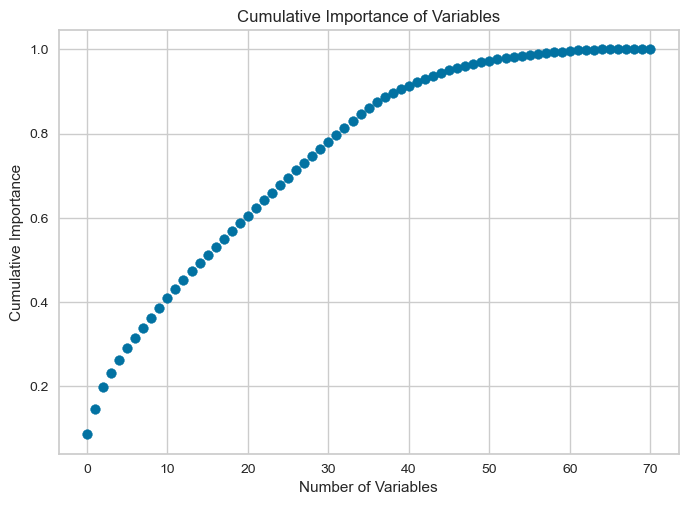

In [42]:
features_a = pd.get_dummies(features)
variables, importances = etc_importances(features_a, outcome_appetency)
sum_importances = sum_and_plot_importances(variables, importances)

In [43]:
features_a = keep_vars(features_a, sum_importances, threshold = 0.99)
features_a.shape

(50000, 57)

This part concatenates the preprocessed features with the target variable, and then converts the entire dataset into dummy variables.


In [44]:
preprocessed_data = pd.concat([features_a, outcome_appetency], axis=1)
preprocessed_data = pd.get_dummies(preprocessed_data, dtype=int)

This section sets up the machine learning experiment using PyCaret, includes a variety of models, and compares them based on AUC score. It selects the best-performing model.



In [45]:
models = ['ada', 'gbc', 'lda', 'ridge', 'nb', 'dt', 'lr', 'qda', 'et', 'rf', 'svm']

exp = setup(preprocessed_data, target='Appetency')
best_model = compare_models(sort='AUC', include=models)
best_model

,Description,Value
0,Session id,2502
1,Target,Appetency
2,Target type,Binary
3,Target mapping,"-1: 0, 1: 1"
4,Original data shape,"(50000, 58)"
5,Transformed data shape,"(50000, 58)"
6,Transformed train set shape,"(35000, 58)"
7,Transformed test set shape,"(15000, 58)"
8,Numeric features,40
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9819,0.8236,0.9819,0.9647,0.9732,-0.0007,-0.0022,2.6050
lda,Linear Discriminant Analysis,0.9819,0.8105,0.9819,0.9656,0.9733,0.0024,0.0068,0.0490
ada,Ada Boost Classifier,0.9822,0.8009,0.9822,0.9660,0.9735,0.0059,0.0140,0.5120
ridge,Ridge Classifier,0.9822,0.7883,0.9822,0.9647,0.9734,0.0000,0.0000,0.0390
rf,Random Forest Classifier,0.9821,0.7462,0.9821,0.9647,0.9733,-0.0002,-0.0006,0.8620
et,Extra Trees Classifier,0.9818,0.7259,0.9818,0.9647,0.9732,-0.0008,-0.0023,0.4900
qda,Quadratic Discriminant Analysis,0.6556,0.6129,0.6556,0.9695,0.7691,0.0157,0.0434,0.0620
nb,Naive Bayes,0.9623,0.5706,0.9623,0.9650,0.9636,-0.0023,-0.0023,0.0330
dt,Decision Tree Classifier,0.9618,0.5180,0.9618,0.9662,0.9639,0.0320,0.0323,0.1630
lr,Logistic Regression,0.9822,0.4540,0.9822,0.9665,0.9735,0.0031,0.0125,1.0800


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=2502, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

This part splits the data into features and target variable, and further splits it into training and testing sets.

In [49]:
# Split the data into features and target
X = preprocessed_data.drop('Appetency', axis=1)
y = preprocessed_data['Appetency']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This section initializes a GradientBoostingClassifier, sets up a parameter grid for hyperparameter tuning, and performs GridSearchCV for model tuning.

In [50]:
# Initialize the GradientBoostingClassifier model
base_model = GradientBoostingClassifier()

# Define the parameters for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)

# Perform model tuning
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

Finally, it evaluates the best model found by GridSearchCV, prints the cross-validation ROC AUC score, tests it on the test set, saves the model, and prints the time taken for the GridSearchCV process.

In [52]:
# Best model found
best_model = grid_search.best_estimator_

cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC score:", cv_score.mean())

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate ROC AUC score on the test set
test_roc_auc = roc_auc_score(y_test, y_pred)
print("Test ROC AUC score:", test_roc_auc)

Cross-validation ROC AUC score: 0.8214754978172388
Test ROC AUC score: 0.4998983016373436


In [ ]:
# Save the model
model_name = '../models/best_model_appetency.joblib'
dump(best_model, model_name)

# Print the time taken for GridSearchCV
print("GridSearchCV took {:.2f} seconds".format(end_time - start_time))

## Stage 3: Modeling Upselling (Propensity to Buy Upgrades)

In [54]:
path = '../data/raw/orange_small_train_upselling.labels'
outcome_upselling = pd.read_csv(path, header = None).rename(columns={0: 'Upselling'})

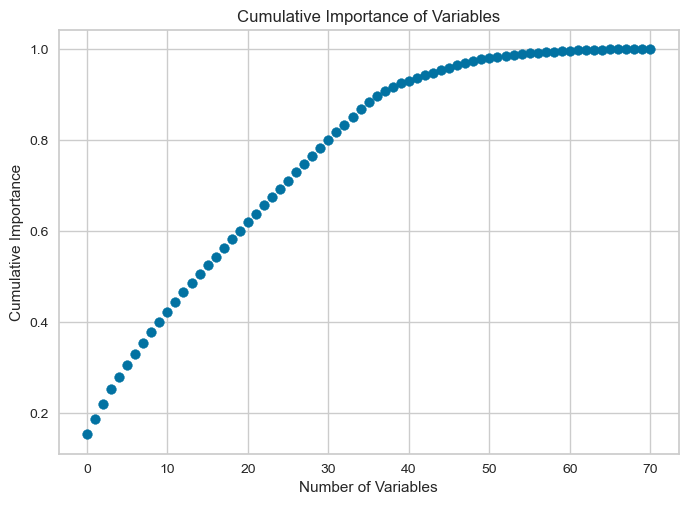

In [58]:
# Preprocessamento
features_u = pd.get_dummies(features)
variables, importances = etc_importances(features_u, outcome_upselling)
sum_importances = sum_and_plot_importances(variables, importances)
features_u = keep_vars(features_u, sum_importances, threshold=0.99)
preprocessed_data = pd.concat([features_u, outcome_upselling], axis=1)
preprocessed_data = pd.get_dummies(preprocessed_data, dtype=int)

In [59]:
# Configurar experimento
exp = setup(preprocessed_data, target='Upselling')
best_model = compare_models(sort='AUC')

,Description,Value
0,Session id,5941
1,Target,Upselling
2,Target type,Binary
3,Target mapping,"-1: 0, 1: 1"
4,Original data shape,"(50000, 56)"
5,Transformed data shape,"(50000, 56)"
6,Transformed train set shape,"(35000, 56)"
7,Transformed test set shape,"(15000, 56)"
8,Numeric features,41
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9507,0.8626,0.9507,0.9456,0.9441,0.5453,0.5724,2.8710
ada,Ada Boost Classifier,0.9497,0.8566,0.9497,0.9441,0.9427,0.5337,0.5613,0.5760
lightgbm,Light Gradient Boosting Machine,0.9505,0.8548,0.9505,0.9455,0.9434,0.5372,0.5680,12.3740
rf,Random Forest Classifier,0.9498,0.8293,0.9498,0.9450,0.9415,0.5172,0.5555,1.1410
et,Extra Trees Classifier,0.9365,0.8021,0.9365,0.9318,0.9160,0.2601,0.3601,0.7110
lda,Linear Discriminant Analysis,0.9308,0.7779,0.9308,0.9181,0.9054,0.1549,0.2487,0.0450
ridge,Ridge Classifier,0.9146,0.7129,0.9146,0.8603,0.8861,0.0032,0.0023,0.0410
dt,Decision Tree Classifier,0.9068,0.6813,0.9068,0.9110,0.9088,0.3464,0.3469,0.1980
nb,Naive Bayes,0.4375,0.6069,0.4375,0.8855,0.5415,0.0337,0.0726,0.0420
svm,SVM - Linear Kernel,0.8993,0.5849,0.8993,0.8647,0.8795,0.0096,0.0097,0.2840


In [62]:
# Dividir os dados
X = preprocessed_data.drop('Upselling', axis=1)
y = preprocessed_data['Upselling']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Treinar modelo
base_model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [64]:
# Avaliar modelo
cv_score = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc').mean()
y_pred = best_model.predict(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred)

# Save the model
model_name = '../models/best_model_upselling.joblib'
dump(best_model, model_name)

print("Cross-validation ROC AUC score:", cv_score)
print("Test ROC AUC score:", test_roc_auc)

Cross-validation ROC AUC score: 0.8640524955837208
Test ROC AUC score: 0.7085200873346993


: 